In [109]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import plotly.graph_objects as go
from datetime import datetime
import time
from openpyxl import load_workbook
from scipy.interpolate import griddata,interp1d

In [2]:
excel_file = open('/Volumes/Windows Dat/TETHER2/TETHER2_DFDRs/DFDR_Test03_v2.xlsx','rb')
headers = pd.read_excel(excel_file,sheet_name = 'DFDR',
                  header=None,nrows=3)
headers = headers.fillna(method='ffill',axis=1)
data = pd.read_excel(excel_file,sheet_name = 'DFDR',
                  header=None,skiprows=3)
excel_file.close()
headers

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,"A1 TETHER TEST 2, DFDR",KEY TIMES,KEY TIMES,KEY TIMES,KEY TIMES,ARDUINO BLACKBOX,ARDUINO BLACKBOX,ARDUINO BLACKBOX,ARDUINO BLACKBOX,ARDUINO BLACKBOX,...,TRANSMITTER,TRANSMITTER,TRANSMITTER,TRANSMITTER,TRANSMITTER,TRANSMITTER,TRANSMITTER,TRANSMITTER,VTP CAM,VTP CAM
1,TEST 03 (24/11/2020),TEST 03 (24/11/2020),TEST 03 (24/11/2020),TEST 03 (24/11/2020),TEST 03 (24/11/2020),ADP (Raw),ADP (Raw),ADP (Corrected),ADP (Corrected),WINGTIP STATUS,...,TRANSMITTER 1 LOG,TRANSMITTER 1 LOG,TRANSMITTER 1 LOG,TRANSMITTER 1 LOG,TRANSMITTER 1 LOG,TRANSMITTER 1 LOG,TRANSMITTER 1 LOG,TRANSMITTER 1 LOG,FWT ANGLES,FWT ANGLES
2,Test Points,Unix Time (s),Master Stopwatch (s),VTP Cam Time (s),Transmitter 1 Time,Alpha (deg),Beta (deg),Alpha (deg),Beta (deg),Right Wingtip,...,RB1V(V),RB2V(V),RB1C(mAh),RB2C(mAh),RBCS,RBS,6P,FWT Comm,Left,Right


In [3]:
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,NaN,1.606221e+09,-46.83,NaN,12:31:19.330000,0.04,-0.08,NaN,NaN,0,...,6.46,6.47,7,3,0,0,-1024,NaN,NaN,NaN
1,NaN,1.606221e+09,-46.82,NaN,12:31:19.350000,0.00,0.00,NaN,NaN,0,...,6.46,6.47,7,3,0,0,-1024,NaN,NaN,NaN
2,NaN,1.606221e+09,-46.8,NaN,12:31:19.360000,0.00,-0.04,NaN,NaN,0,...,6.46,6.47,7,3,0,0,-1024,NaN,NaN,NaN
3,NaN,1.606221e+09,-46.78,NaN,12:31:19.380000,0.04,0.00,NaN,NaN,0,...,6.48,6.45,7,3,0,0,-1024,NaN,NaN,NaN
4,NaN,1.606221e+09,-46.77,NaN,12:31:19.390000,0.04,-0.04,NaN,NaN,0,...,6.48,6.45,7,3,0,0,-1024,NaN,NaN,NaN


In [4]:
def get_angle_data(filename,flip=False):
    df2 = pd.read_csv(filename)
    df2['t'] = df2['Frame']/df2['fps']
    df2['x_delta'] = df2['x0'] - df2['x1']
    df2['y_delta'] = df2['y0'] - df2['y1']
    df2['x_delta'] = df2['x_delta'].where((df2['x0']>df2['x1']).to_list(),df2['x1']-df2['x0'])
    df2['y_delta'] = df2['y_delta'].where((df2['x0']>df2['x1']).to_list(),df2['y1']-df2['y0'])
    df2['angle'] = np.rad2deg(np.arctan2(df2['y_delta'],df2['x_delta']))
    df2['angle'] = df2['angle'] if not flip else -df2['angle']
    return df2

In [89]:
df_left = get_angle_data('/Volumes/Windows Dat/TETHER2/TETHER2_2A.1/VID/tail/first_part/RC_VID_0000_left_data.csv',False)
df_right = get_angle_data('/Volumes/Windows Dat/TETHER2/TETHER2_2A.1/VID/tail/first_part/RC_VID_0000_right_data.csv',True)

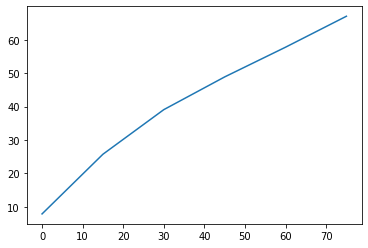

In [110]:
calib_left = pickle.load(open('/Volumes/Windows Dat/TETHER2/TETHER2_2A.1/VID/tail/first_part/RC_VID_0000_left_calib.pkl','rb'))
calib_right = pickle.load(open('/Volumes/Windows Dat/TETHER2/TETHER2_2A.1/VID/tail/first_part/RC_VID_0000_right_calib.pkl','rb'))


left_calib_func = interp1d(calib_left['angle_act'],calib_left['angle_calib'],fill_value='extrapolate')
right_calib_func = interp1d(calib_right['angle_act'],calib_right['angle_calib'],fill_value='extrapolate')

df_left['angle_calib'] = left_calib_func(df_left['angle'])
df_right['angle_calib'] = right_calib_func(df_right['angle'])

plt.plot(calib_left['angle_calib'],calib_left['angle_act'])

In [111]:
f_left = interp1d(df_left['t']-19.28,df_left['angle_calib'],bounds_error=False)
f_right = interp1d(df_right['t']-19.28,df_right['angle_calib'],bounds_error=False)

In [112]:
ind = np.logical_and((data[2][:-3]-19.28) >= min(df_left['t']-19.28),(data[2][:-3]-19.28) <= max(df_left['t']-19.28))
ind = [*ind,*[False]*3]
data.loc[ind,43] = f_left(data.loc[ind,2].to_list())
data.loc[ind,44] = f_right(data.loc[ind,2].to_list())

left_angle = data.loc[ind,43].to_list()
right_angle = data.loc[ind,44].to_list()
alpha = data.loc[ind,5].to_list()
beta = data.loc[ind,6].to_list()

Text(0.5, 0, 'alpha [deg]')

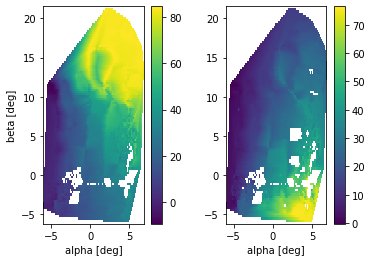

In [119]:
from scipy.interpolate import griddata

alpha_line = np.linspace(min(alpha), max(alpha), 100)
beta_line = np.linspace(min(beta), max(beta), 100)
alpha_grid,beta_grid = np.meshgrid(alpha_line, beta_line)

grid_z1 = griddata(list(map(list,zip(alpha,beta))), left_angle, (alpha_grid, beta_grid), method='linear')
plt.subplot(121)
plt.imshow(grid_z1, extent=(min(alpha),max(alpha),min(beta),max(beta)),origin='lower')
plt.colorbar()
plt.xlabel('alpha [deg]')
plt.ylabel('beta [deg]')

grid_z1 = griddata(list(map(list,zip(alpha,beta))), right_angle, (alpha_grid, beta_grid), method='linear')
plt.subplot(122)
plt.imshow(grid_z1, extent=(min(alpha),max(alpha),min(beta),max(beta)), origin='lower')
plt.colorbar()
plt.xlabel('alpha [deg]')

In [140]:
alpha_line = np.linspace(min(alpha),max(alpha),100)
beta_line = np.linspace(min(beta),max(beta),100)
alpha_delta = (alpha_line[1]-alpha_line[0])/2
beta_delta = (beta_line[1]-beta_line[0])/2

res_left = []
res_right = []

for xi,a in enumerate(alpha_line):
    ind_alpha = np.logical_and(np.array(alpha)>=a-alpha_delta,np.array(alpha)<a+alpha_delta)
    alpha_tmp = np.array(alpha)[ind_alpha]
    beta_tmp = np.array(beta)[ind_alpha]
    left_tmp = np.array(left_angle)[ind_alpha]
    right_tmp = np.array(right_angle)[ind_alpha]
    for yi,b in enumerate(beta_line):
        ind_beta = np.logical_and(beta_tmp>=b-beta_delta,beta_tmp<b+beta_delta)
        left_angles =left_tmp[ind_beta]
        right_angles = right_tmp[ind_beta]
        if left_angles.size>0:
            res_left.append(([a,b],np.nanmedian(left_angles)))
        if right_angles.size>0:
            res_right.append(([a,b],np.nanmedian(right_angles)))

alpha_grid,beta_grid = np.meshgrid(alpha_line, beta_line)
grid_z1 = griddata(*zip(*res_left), (alpha_grid, beta_grid), method='linear')
plt.subplot(121)
plt.imshow(grid_z1, extent=(min(alpha),max(alpha),min(beta),max(beta)),origin='lower')
plt.colorbar()
plt.xlabel('alpha [deg]')
plt.ylabel('beta [deg]')

grid_z1 = griddata(*zip(*res_right), (alpha_grid, beta_grid), method='linear')
plt.subplot(122)
plt.imshow(grid_z1, extent=(min(alpha),max(alpha),min(beta),max(beta)), origin='lower')
plt.colorbar()
plt.xlabel('alpha [deg]')

SyntaxError: invalid syntax (<ipython-input-140-582463f9c903>, line 19)

In [139]:
res_left==np.NaN

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
delta = 315.2
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_left['t'], y=df_left['angle_calib'],
                    mode='lines',
                    name='left'))
fig.add_trace(go.Scatter(x=df_right['t'], y=df_right['angle_calib'],
                    mode='lines',
                    name='calib'))
# fig.add_trace(go.Scatter(x=df_right['t']+delta, y=-df_right['angle']+df_left['angle'],
#                     mode='lines',
#                     name='delta'))
fig.add_trace(go.Scatter(x=df[0][2:]-df[0][2], y=df[57][2:],
                    mode='lines',
                    name='roll'))
fig.add_trace(go.Scatter(x=df[0][2:]-df[0][2], y=df[55][2:]*25,
                    mode='lines',
                    name='status'))

fig.show()